In [ ]:
## 关于学生叙述能力的差异分析(宏观叙事-段落长度)

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway, tukey_hsd, levene, shapiro
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体和图表样式
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

def load_and_prepare_data():
    """加载和准备数据"""
    # 读取数据
    data = pd.read_csv('../pre_data/宏观叙事-段落长度-grade.csv')
    
    # 将年级标签转换为更易理解的名称
    grade_mapping = {1: '高一', 2: '高二', 3: '高三'}
    data['年级名称'] = data['年级'].map(grade_mapping)
    
    # 按年级分组数据
    grade_groups = {grade: group for grade, group in data.groupby('年级名称')}
    
    return data, grade_groups
data, grade_groups = load_and_prepare_data()

In [6]:
def descriptive_statistics_paragraph_length(data, grade_groups):
    """宏观叙事段落长度描述性统计分析"""
    print("=" * 80)
    print("宏观叙事段落长度描述性统计分析报告")
    print("=" * 80)
    
    # 1. 基本统计信息
    print("\n1. 数据基本信息：")
    print(f"总样本数：{len(data)}")
    print(f"年级分布：\n{data['年级名称'].value_counts().sort_index()}")
    
    # 2. 各年级描述性统计
    print("\n2. 各年级描述性统计：")
    
    indicators = {
        '段落平均长度': '段落平均长度-DESPL-04',
        '段落平均长度标准差': '段落平均长度标准差-DESPLd-05'
    }
    
    for grade_name in ['高一', '高二', '高三']:
        print(f"\n{grade_name}：")
        print(f"  样本数：{len(grade_groups[grade_name])}")
        for indicator_name, indicator_col in indicators.items():
            values = grade_groups[grade_name][indicator_col]
            mean_val = values.mean()
            std_val = values.std()
            print(f"  {indicator_name} - 均值：{mean_val:.3f}, 标准差：{std_val:.3f}")
    
    # 3. 正态性检验
    print("\n3. 正态性检验：")
    for grade_name in ['高一', '高二', '高三']:
        print(f"\n{grade_name}：")
        for indicator_name, indicator_col in indicators.items():
            values = grade_groups[grade_name][indicator_col]
            stat, p_value = shapiro(values)
            normality = "正态分布" if p_value > 0.05 else "非正态分布"
            print(f"  {indicator_name} - Shapiro-Wilk检验：W={stat:.4f}, p={p_value:.4f} ({normality})")
    
    # 4. 方差齐性检验
    print("\n4. 方差齐性检验：")
    for indicator_name, indicator_col in indicators.items():
        grade1_data = grade_groups['高一'][indicator_col]
        grade2_data = grade_groups['高二'][indicator_col]
        grade3_data = grade_groups['高三'][indicator_col]
        
        stat, p_value = levene(grade1_data, grade2_data, grade3_data)
        homogeneity = "方差齐性" if p_value > 0.05 else "方差非齐性"
        print(f"{indicator_name} - Levene检验：F={stat:.4f}, p={p_value:.4f} ({homogeneity})")
    
    # 5. 年级间比较分析
    print("\n5. 年级间比较分析：")
    for indicator_name, indicator_col in indicators.items():
        print(f"\n{indicator_name}年级间比较：")
        grade1_data = grade_groups['高一'][indicator_col]
        grade2_data = grade_groups['高二'][indicator_col]
        grade3_data = grade_groups['高三'][indicator_col]
        
        # 单因素方差分析
        f_stat, p_value = f_oneway(grade1_data, grade2_data, grade3_data)
        print(f"  单因素方差分析：F={f_stat:.4f}, p={p_value:.4f}")
        
        if p_value < 0.05:
            print("  结果：存在显著性差异")
            # Tukey HSD事后检验
            tukey_result = tukey_hsd(grade1_data, grade2_data, grade3_data)
            print("  Tukey HSD事后检验结果：")
            print(f"    高一 vs 高二：p={tukey_result.pvalue[0][1]:.4f}")
            print(f"    高一 vs 高三：p={tukey_result.pvalue[0][2]:.4f}")
            print(f"    高二 vs 高三：p={tukey_result.pvalue[1][2]:.4f}")
        else:
            print("  结果：无显著性差异")
    
    # 6. 年级内比较分析
    print("\n6. 年级内比较分析：")
    
    # 定义指标组
    paragraph_length_indicators = ['段落平均长度-DESPL-04']
    paragraph_std_indicators = ['段落平均长度标准差-DESPLd-05']
    
    for grade_name in ['高一', '高二', '高三']:
        print(f"\n{grade_name}内部差异分析：")
        
        # 计算段落平均长度指标的平均变异系数
        length_cvs = []
        for indicator in paragraph_length_indicators:
            values = grade_groups[grade_name][indicator]
            cv = (values.std() / values.mean()) * 100
            length_cvs.append(cv)
        avg_length_cv = np.mean(length_cvs)
        
        # 计算段落平均长度标准差指标的平均变异系数
        std_cvs = []
        for indicator in paragraph_std_indicators:
            values = grade_groups[grade_name][indicator]
            cv = (values.std() / values.mean()) * 100
            std_cvs.append(cv)
        avg_std_cv = np.mean(std_cvs)
        
        # 比较差异程度
        if avg_length_cv > avg_std_cv:
            max_diff_group = "段落平均长度指标"
            max_cv = avg_length_cv
            min_diff_group = "段落平均长度标准差指标"
            min_cv = avg_std_cv
        else:
            max_diff_group = "段落平均长度标准差指标"
            max_cv = avg_std_cv
            min_diff_group = "段落平均长度指标"
            min_cv = avg_length_cv
        
        print(f"  各组指标平均变异系数（从大到小排序）：")
        print(f"    {max_diff_group}：{max_cv:.2f}%")
        print(f"    {min_diff_group}：{min_cv:.2f}%")
        print(f"  差异程度最大的指标组：{max_diff_group}（平均变异系数：{max_cv:.2f}%）")
        print(f"  该指标组是影响{grade_name}阶段能力发展的关键因素")
        
        # 显示各指标的具体变异系数
        print(f"  {max_diff_group}内部各指标变异系数：")
        if max_diff_group == "段落平均长度指标":
            for i, indicator in enumerate(paragraph_length_indicators):
                values = grade_groups[grade_name][indicator]
                cv = (values.std() / values.mean()) * 100
                print(f"    {indicator}：{cv:.2f}%")
        else:
            for i, indicator in enumerate(paragraph_std_indicators):
                values = grade_groups[grade_name][indicator]
                cv = (values.std() / values.mean()) * 100
                print(f"    {indicator}：{cv:.2f}%")
    
    print("\n" + "=" * 80)
    print("分析结论")
    print("=" * 80)

def create_paragraph_length_boxplots(data, grade_groups, save_path='../res/宏观叙事段落长度箱线图比较.png'):
    """创建宏观叙事段落长度箱线图比较 - 采用高级美观的seaborn风格"""
    print("生成宏观叙事段落长度箱线图...")
    
    # 设置全局风格
    sns.set_theme(style="whitegrid", font="SimHei", rc={
        "axes.titlesize": 20,
        "axes.labelsize": 16,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 14,
        "axes.titleweight": "bold"
    })
    plt.rcParams['axes.unicode_minus'] = False

    # 设置颜色主题
    colors = ['#2E86AB', '#A23B72', '#F18F01']
    grade_names = ['高一', '高二', '高三']
    
    # 定义指标
    indicators = {
        '段落平均长度': '段落平均长度-DESPL-04',
        '段落平均长度标准差': '段落平均长度标准差-DESPLd-05'
    }
    
    # 创建图形
    fig, axes = plt.subplots(1, 2, figsize=(16, 8), dpi=120, constrained_layout=True)
    fig.suptitle('宏观叙事段落长度各指标年级间分布对比', fontsize=22, fontweight='bold', y=0.95)
    
    # 绘制箱线图
    for i, (indicator_name, indicator_col) in enumerate(indicators.items()):
        ax = axes[i]
        
        # 准备数据
        data_list = [grade_groups[grade][indicator_col] for grade in grade_names]
        
        # 构造DataFrame用于seaborn
        df_data = pd.DataFrame({
            '年级': np.repeat(grade_names, [len(x) for x in data_list]),
            '数值': np.concatenate(data_list)
        })
        
        # 绘制小提琴图+箱线图
        sns.violinplot(
            x='年级', y='数值', data=df_data, ax=ax,
            inner=None, palette=colors, linewidth=0, alpha=0.18
        )
        sns.boxplot(
            x='年级', y='数值', data=df_data, ax=ax,
            width=0.25, palette=colors, boxprops=dict(alpha=0.7)
        )
        
        # 均值点
        means = df_data.groupby('年级')['数值'].mean()
        ax.scatter(range(len(grade_names)), means, color='#E74C3C', s=120, marker='D', 
                  edgecolor='white', zorder=10, label='均值')
        
        # 美化
        ax.set_title(indicator_name, fontsize=18, fontweight='bold', color='#222')
        ax.set_xlabel('年级', fontsize=14, fontweight='bold')
        ax.set_ylabel('数值', fontsize=14, fontweight='bold')
        ax.grid(axis='y', linestyle='--', alpha=0.25)
        ax.set_axisbelow(True)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # 自定义图例
        from matplotlib.patches import Patch
        from matplotlib.lines import Line2D
        legend_elements = [
            Patch(facecolor='#2E86AB', edgecolor='#2E86AB', label='高一', alpha=0.7),
            Patch(facecolor='#A23B72', edgecolor='#A23B72', label='高二', alpha=0.7),
            Patch(facecolor='#F18F01', edgecolor='#F18F01', label='高三', alpha=0.7),
            Line2D([0], [0], marker='D', color='w', label='均值', markerfacecolor='#E74C3C', 
                   markeredgecolor='white', markersize=12)
        ]
        ax.legend(handles=legend_elements, loc='upper right', frameon=True, fancybox=True, shadow=True)
    
    # 调整布局
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"箱线图已保存到: {save_path}")

def create_paragraph_length_heatmap(data, grade_groups, save_path='../res/宏观叙事段落长度变异系数热力图.png'):
    """创建宏观叙事段落长度变异系数热力图 - 采用高级美观的seaborn风格"""
    print("生成宏观叙事段落长度变异系数热力图...")
    
    # 设置全局风格
    sns.set_theme(style="whitegrid", font="SimHei", rc={
        "axes.titlesize": 20,
        "axes.labelsize": 16,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 14,
        "axes.titleweight": "bold"
    })
    plt.rcParams['axes.unicode_minus'] = False

    # 定义指标
    indicators = {
        '段落平均长度': '段落平均长度-DESPL-04',
        '段落平均长度标准差': '段落平均长度标准差-DESPLd-05'
    }
    
    grade_names = ['高一', '高二', '高三']
    
    # 计算各年级各指标的变异系数
    cv_matrix = []
    for grade in grade_names:
        grade_data = grade_groups[grade]
        cv_row = []
        for name, col in indicators.items():
            cv = grade_data[col].std() / grade_data[col].mean() * 100
            cv_row.append(cv)
        cv_matrix.append(cv_row)
    
    cv_matrix = np.array(cv_matrix)
    
    # 创建图形
    fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=120, constrained_layout=True,layout='constrained')
    
    # 创建热力图
    im = sns.heatmap(
        cv_matrix, 
        annot=True, 
        cmap='RdYlBu_r', 
        center=cv_matrix.mean(),
        square=True, 
        linewidths=2, 
        cbar_kws={"shrink": .8, "label": "变异系数 (%)"},
        ax=ax, 
        fmt='.1f', 
        annot_kws={'size': 14, 'weight': 'bold'},
        xticklabels=list(indicators.keys()),
        yticklabels=grade_names
    )
    
    # 设置标题和标签
    ax.set_title('宏观叙事段落长度各年级各指标变异系数热力图', fontsize=18, fontweight='bold', color='#222', pad=20)
    ax.set_xlabel('指标', fontsize=16, fontweight='bold', color='#222')
    ax.set_ylabel('年级', fontsize=16, fontweight='bold', color='#222')
    
    # 美化坐标轴
    ax.tick_params(axis='both', which='major', labelsize=12, labelcolor='#222')
    
    # 旋转x轴标签以提高可读性
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # 调整布局
    #plt.tight_layout()
    
    # 保存图片
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"热力图已保存到: {save_path}")

def create_paragraph_length_density_plots(data, grade_groups, save_path='../res/宏观叙事段落长度密度图.png'):
    """创建宏观叙事段落长度密度图 - 采用高级美观的seaborn风格"""
    print("生成宏观叙事段落长度密度图...")
    
    # 设置全局风格
    sns.set_theme(style="whitegrid", font="SimHei", rc={
        "axes.titlesize": 18,
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
        "axes.titleweight": "bold"
    })
    plt.rcParams['axes.unicode_minus'] = False

    # 设置颜色主题
    colors = ['#2E86AB', '#A23B72', '#F18F01']
    grade_names = ['高一', '高二', '高三']
    
    # 定义指标
    indicators = {
        '段落平均长度': '段落平均长度-DESPL-04',
        '段落平均长度标准差': '段落平均长度标准差-DESPLd-05'
    }
    
    # 创建图形
    fig, axes = plt.subplots(1, 2, figsize=(16, 8), dpi=120, constrained_layout=True)
    fig.suptitle('宏观叙事段落长度各指标分布密度图', fontsize=20, fontweight='bold', y=0.95)
    
    # 绘制密度图
    for i, (indicator_name, indicator_col) in enumerate(indicators.items()):
        ax = axes[i]
        
        # 绘制每个年级的密度图
        for j, grade_name in enumerate(grade_names):
            values = grade_groups[grade_name][indicator_col]
            
            # 绘制直方图
            ax.hist(values, bins=20, alpha=0.6, density=True, 
                   color=colors[j], edgecolor='white', linewidth=1.5, label=grade_name)
            
            # 添加核密度估计曲线
            from scipy.stats import gaussian_kde
            kde = gaussian_kde(values)
            x_range = np.linspace(values.min(), values.max(), 100)
            ax.plot(x_range, kde(x_range), color=colors[j], linewidth=3, alpha=0.8)
        
        # 设置标题和标签
        ax.set_title(indicator_name, fontsize=16, fontweight='bold', pad=20, color='#2C3E50')
        ax.set_xlabel('数值', fontsize=12, fontweight='bold', color='#2C3E50')
        ax.set_ylabel('密度', fontsize=12, fontweight='bold', color='#2C3E50')
        
        # 添加图例
        ax.legend(fontsize=10, frameon=True, fancybox=True, shadow=True)
        
        # 添加网格
        ax.grid(True, alpha=0.3, linestyle='--')
    
    # 调整布局
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"密度图已保存到: {save_path}")

def create_paragraph_length_visualizations(data, grade_groups):
    """创建宏观叙事段落长度可视化图表 - 主函数"""
    print("开始生成宏观叙事段落长度可视化图表...")
    
    # 创建各种类型的图表
    create_paragraph_length_boxplots(data, grade_groups)
    create_paragraph_length_heatmap(data, grade_groups)
    create_paragraph_length_density_plots(data, grade_groups)
    
    print("所有可视化图表生成完成！")

宏观叙事段落长度描述性统计分析报告

1. 数据基本信息：
总样本数：300
年级分布：
年级名称
高一    100
高三    100
高二    100
Name: count, dtype: int64

2. 各年级描述性统计：

高一：
  样本数：100
  段落平均长度 - 均值：7.400, 标准差：1.584
  段落平均长度标准差 - 均值：1.711, 标准差：1.311

高二：
  样本数：100
  段落平均长度 - 均值：6.695, 标准差：1.499
  段落平均长度标准差 - 均值：2.510, 标准差：1.606

高三：
  样本数：100
  段落平均长度 - 均值：6.895, 标准差：1.380
  段落平均长度标准差 - 均值：1.421, 标准差：1.061

3. 正态性检验：

高一：
  段落平均长度 - Shapiro-Wilk检验：W=0.9713, p=0.0277 (非正态分布)
  段落平均长度标准差 - Shapiro-Wilk检验：W=0.9260, p=0.0000 (非正态分布)

高二：
  段落平均长度 - Shapiro-Wilk检验：W=0.9659, p=0.0108 (非正态分布)
  段落平均长度标准差 - Shapiro-Wilk检验：W=0.9466, p=0.0005 (非正态分布)

高三：
  段落平均长度 - Shapiro-Wilk检验：W=0.9648, p=0.0089 (非正态分布)
  段落平均长度标准差 - Shapiro-Wilk检验：W=0.9014, p=0.0000 (非正态分布)

4. 方差齐性检验：
段落平均长度 - Levene检验：F=0.4580, p=0.6330 (方差齐性)
段落平均长度标准差 - Levene检验：F=9.2981, p=0.0001 (方差非齐性)

5. 年级间比较分析：

段落平均长度年级间比较：
  单因素方差分析：F=5.9440, p=0.0029
  结果：存在显著性差异
  Tukey HSD事后检验结果：
    高一 vs 高二：p=0.0027
    高一 vs 高三：p=0.0451
    高二 vs 高三：p=0.6097

段落平均长度标准差年级间比较：
  单因素方差分析：F=

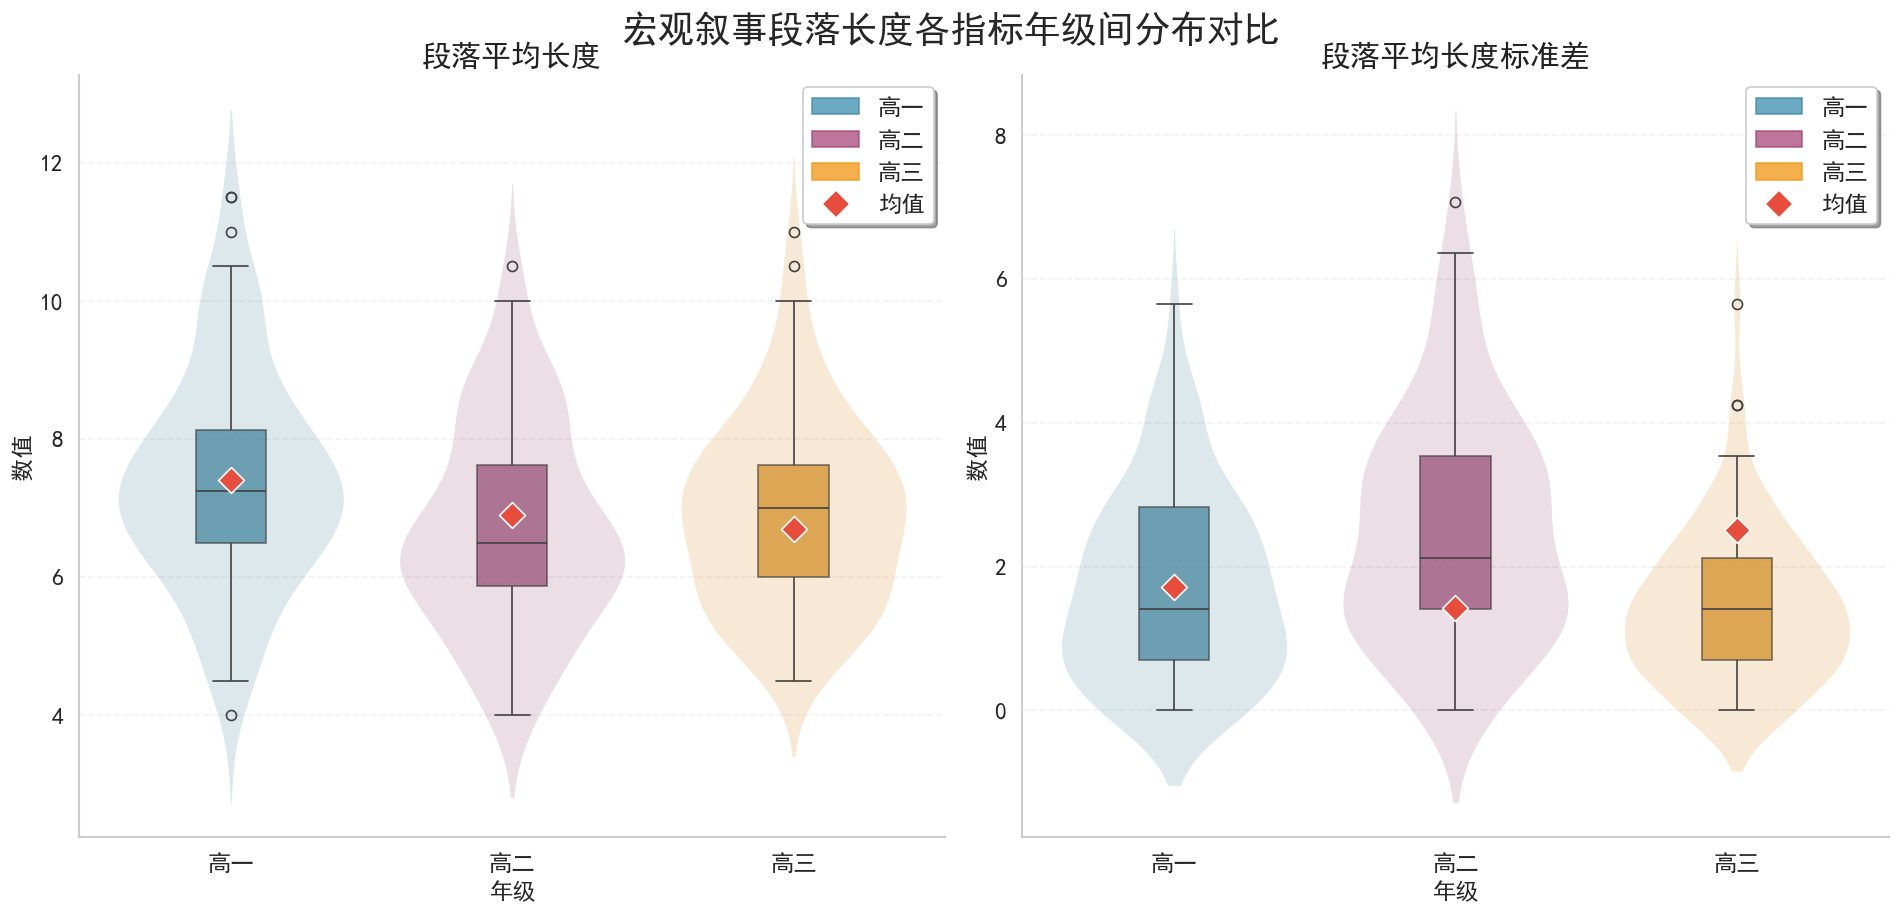

箱线图已保存到: ../res/宏观叙事段落长度箱线图比较.png
生成宏观叙事段落长度变异系数热力图...


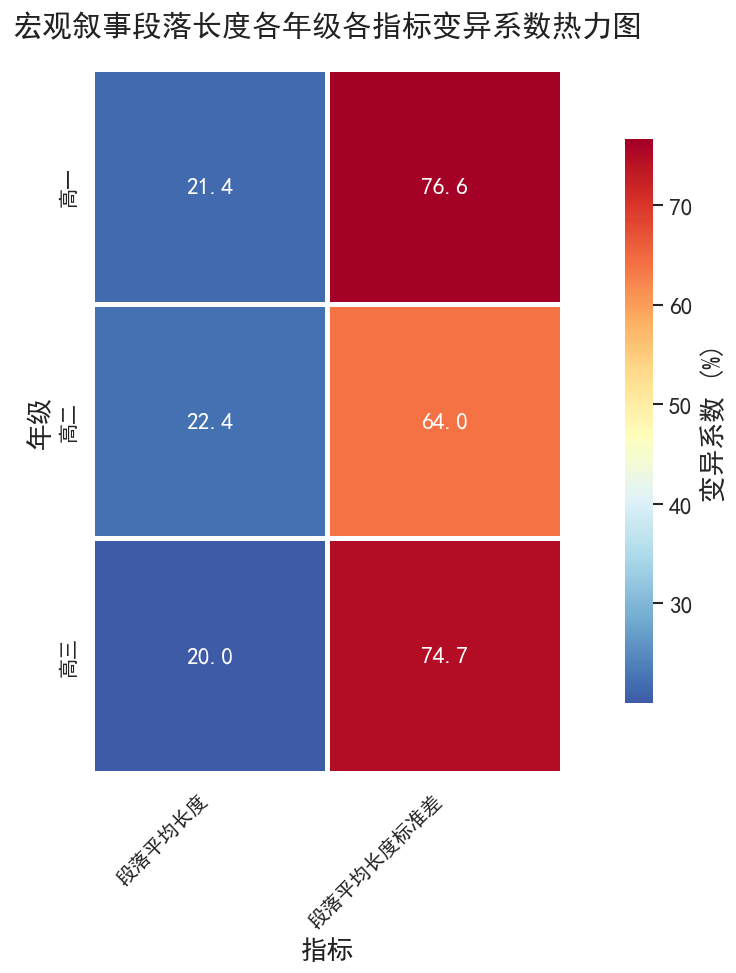

热力图已保存到: ../res/宏观叙事段落长度变异系数热力图.png
生成宏观叙事段落长度密度图...


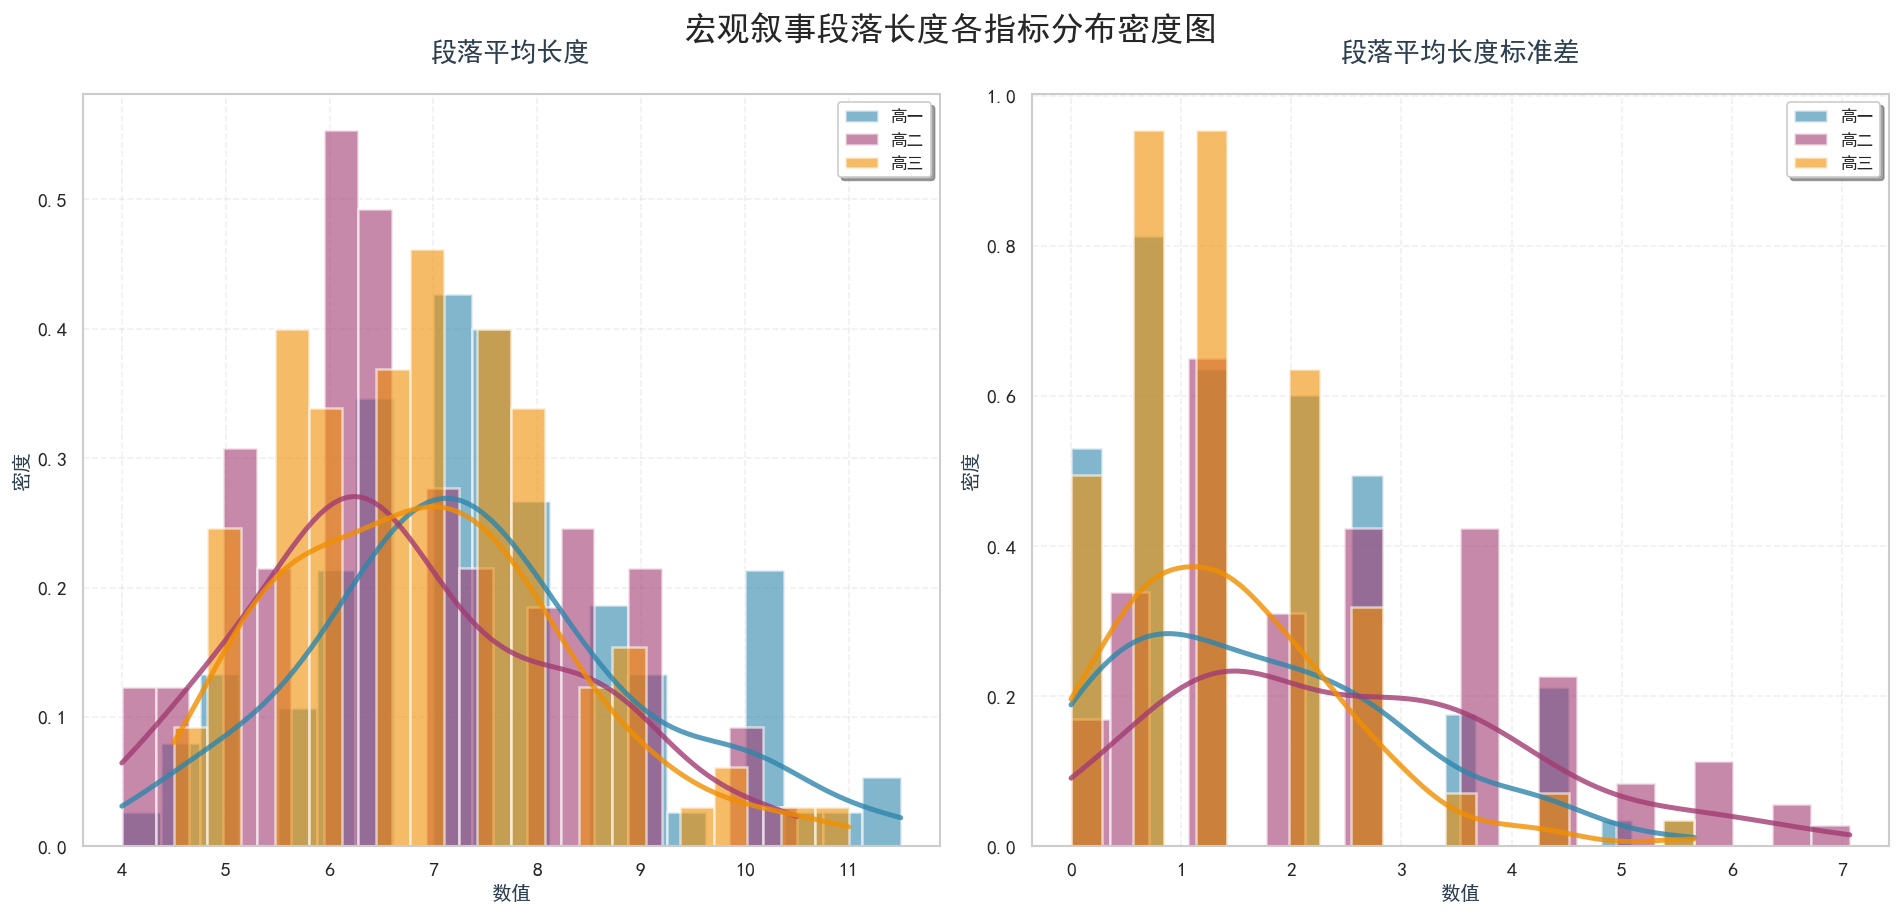

密度图已保存到: ../res/宏观叙事段落长度密度图.png
所有可视化图表生成完成！


FileNotFoundError: [Errno 2] No such file or directory: '../res/res_v2/宏观叙事结构-段落长度/分析结果.txt'

In [7]:
def main():
    """主函数"""
    # 加载数据
    data, grade_groups = load_and_prepare_data()
    
    # 描述性统计分析
    descriptive_statistics_paragraph_length(data, grade_groups)
    
    # 创建可视化图表
    create_paragraph_length_visualizations(data, grade_groups)
    
    # 保存分析结果到文件
    import sys
    from io import StringIO
    
    # 重定向输出到文件
    original_stdout = sys.stdout
    result_file = StringIO()
    sys.stdout = result_file
    
    # 重新运行分析
    descriptive_statistics_paragraph_length(data, grade_groups)
    
    # 恢复输出
    sys.stdout = original_stdout
    
    # 保存结果到文件
    with open('../res/res_v2/宏观叙事结构-段落长度/分析结果.txt', 'w', encoding='utf-8') as f:
        f.write(result_file.getvalue())
    
    print("分析完成！结果已保存到 '../res/res_v2/宏观叙事结构-段落长度/分析结果.txt'")

if __name__ == "__main__":
    main()